# ResNet with Transfer Learning

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import keras
from keras.layers import Input, Dense, Dropout, Flatten
from keras.utils import image_dataset_from_directory
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

2022-11-10 09:58:36.123630: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# CONSTANTS

In [3]:
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (WIDTH, HEIGHT, CHANNELS)
PATH_DATASET_TRAIN = '/mnt/files/Datasets/cats-dogs/training_set/'
PATH_DATASET_TEST = '/mnt/files/Datasets/cats-dogs/test_set/'
BATCH_SIZE = 128
LR_INITIAL = 0.01
N_EPOCHS = 20

# DATASET

## train dataset

In [4]:
train_ds = image_dataset_from_directory(directory=PATH_DATASET_TRAIN,
                                        seed=123,
                                        image_size=(WIDTH, HEIGHT),
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE)

Found 8000 files belonging to 2 classes.


## validation/test dataset

In [5]:
test_ds = image_dataset_from_directory(directory=PATH_DATASET_TEST,
                                       seed=123,
                                       image_size=(WIDTH, HEIGHT),
                                       color_mode='rgb',
                                       batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


## Visualization some examples

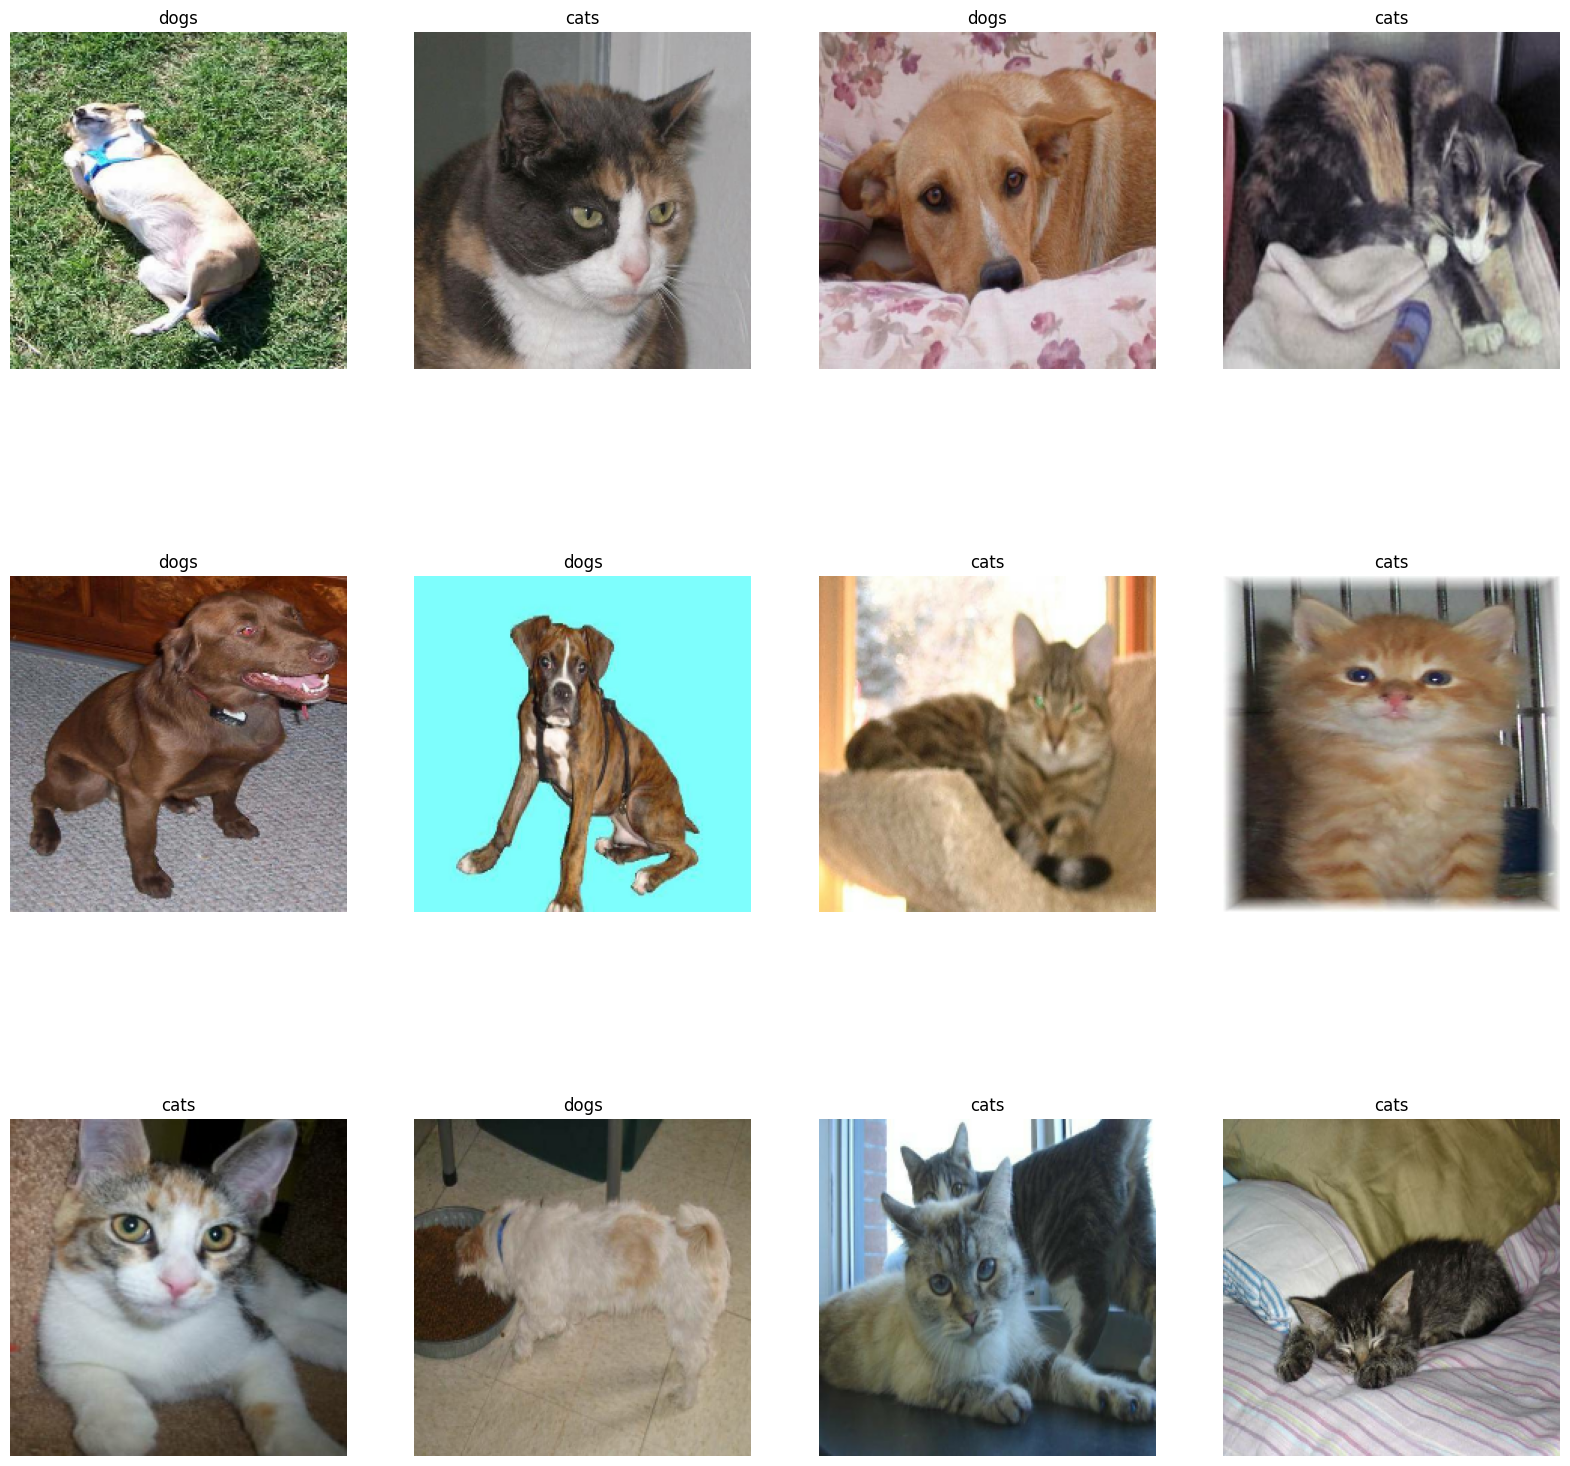

In [7]:
plt.figure(figsize=(20, 20))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# MODEL

## ResNet

In [9]:
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input

### Feature Extraction

In [10]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freezing model
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Complete

In [11]:
inputs = Input(shape=INPUT_SHAPE)
x = preprocess_input(inputs)
x = base_model(x)
x = Flatten()(x)
x = Dense(units=2, activation='softmax', name='softmax')(x)
model = keras.Model(inputs=inputs, outputs=x, name='ResNet50')
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 softmax (Dense)             (None, 2)                 200706    
                                                          

# CALLBACKS

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=10, min_lr=0.5e-6, verbose=1)

checkpoint_filepath = '/tmp/checkpoint/best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

callbacks = [reduce_lr, model_checkpoint_callback]

# OPTIMIZER

In [13]:
optimizer = SGD(learning_rate=LR_INITIAL, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# COMPILE

In [14]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# TRAINING

In [15]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=N_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=callbacks, verbose=1)

Epoch 1/20
63/63 [==============================] - 40s 580ms/step - loss: 3.5355 - accuracy: 0.9676 - val_loss: 3.1144 - val_accuracy: 0.9820 - lr: 0.0100
Epoch 2/20
63/63 [==============================] - 16s 257ms/step - loss: 0.6299 - accuracy: 0.9941 - val_loss: 2.3450 - val_accuracy: 0.9865 - lr: 0.0100
Epoch 3/20
63/63 [==============================] - 16s 252ms/step - loss: 0.3241 - accuracy: 0.9952 - val_loss: 2.1670 - val_accuracy: 0.9870 - lr: 0.0100
Epoch 4/20
63/63 [==============================] - 16s 251ms/step - loss: 0.0670 - accuracy: 0.9992 - val_loss: 2.5413 - val_accuracy: 0.9845 - lr: 0.0100
Epoch 5/20
63/63 [==============================] - 15s 244ms/step - loss: 0.0246 - accuracy: 0.9991 - val_loss: 2.5079 - val_accuracy: 0.9870 - lr: 0.0100
Epoch 6/20
63/63 [==============================] - 16s 250ms/step - loss: 0.0128 - accuracy: 0.9998 - val_loss: 2.6630 - val_accuracy: 0.9870 - lr: 0.0100
Epoch 7/20
63/63 [==============================] - 15s 245ms/st

# EVALUATING

In [17]:
model.load_weights('/tmp/checkpoint/best_model.h5')  # Loading the best model

In [18]:
model.evaluate(test_ds)

16/16 [==============================] - 3s 196ms/step - loss: 2.3382 - accuracy: 0.9880


[2.3382182121276855, 0.9879999756813049]

In [19]:
out = model.evaluate(test_ds)
loss, acc = out[0], out[1]
print(f"loss = {loss:.4f} | acc = {acc:.4f}")

16/16 [==============================] - 3s 195ms/step - loss: 2.3382 - accuracy: 0.9880
loss = 2.3382 | acc = 0.9880


In [20]:
## Curves

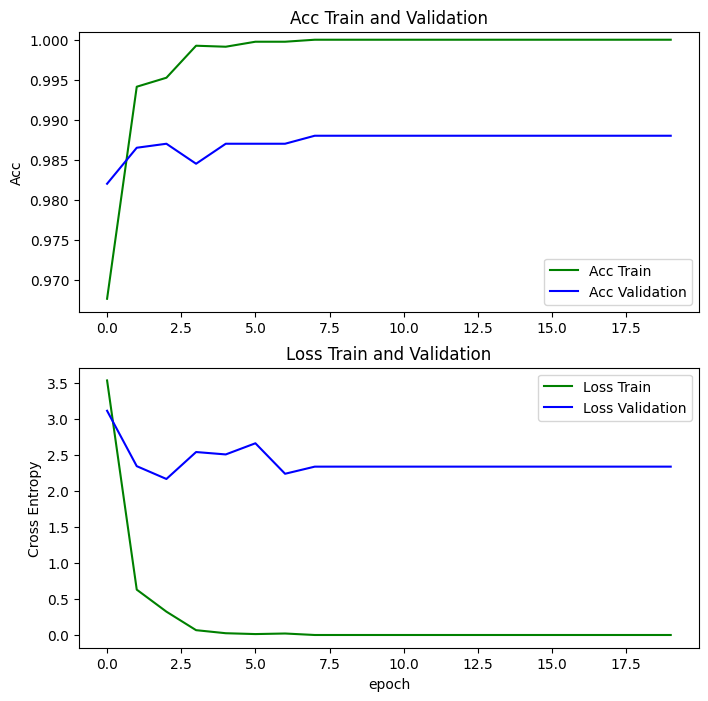

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, 'g', label='Acc Train')
plt.plot(val_acc, 'b', label='Acc Validation')
plt.legend(loc='lower right')
plt.ylabel('Acc')
plt.ylim([min(plt.ylim()),1.001])
plt.title('Acc Train and Validation')

plt.subplot(2, 1, 2)
plt.plot(loss, 'g', label='Loss Train')
plt.plot(val_loss, 'b', label='Loss Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss Train and Validation')
plt.xlabel('epoch')
plt.show()

## Infering some examples (green = correct, red = wrong)

4/4 [==============================] - 1s 41ms/step


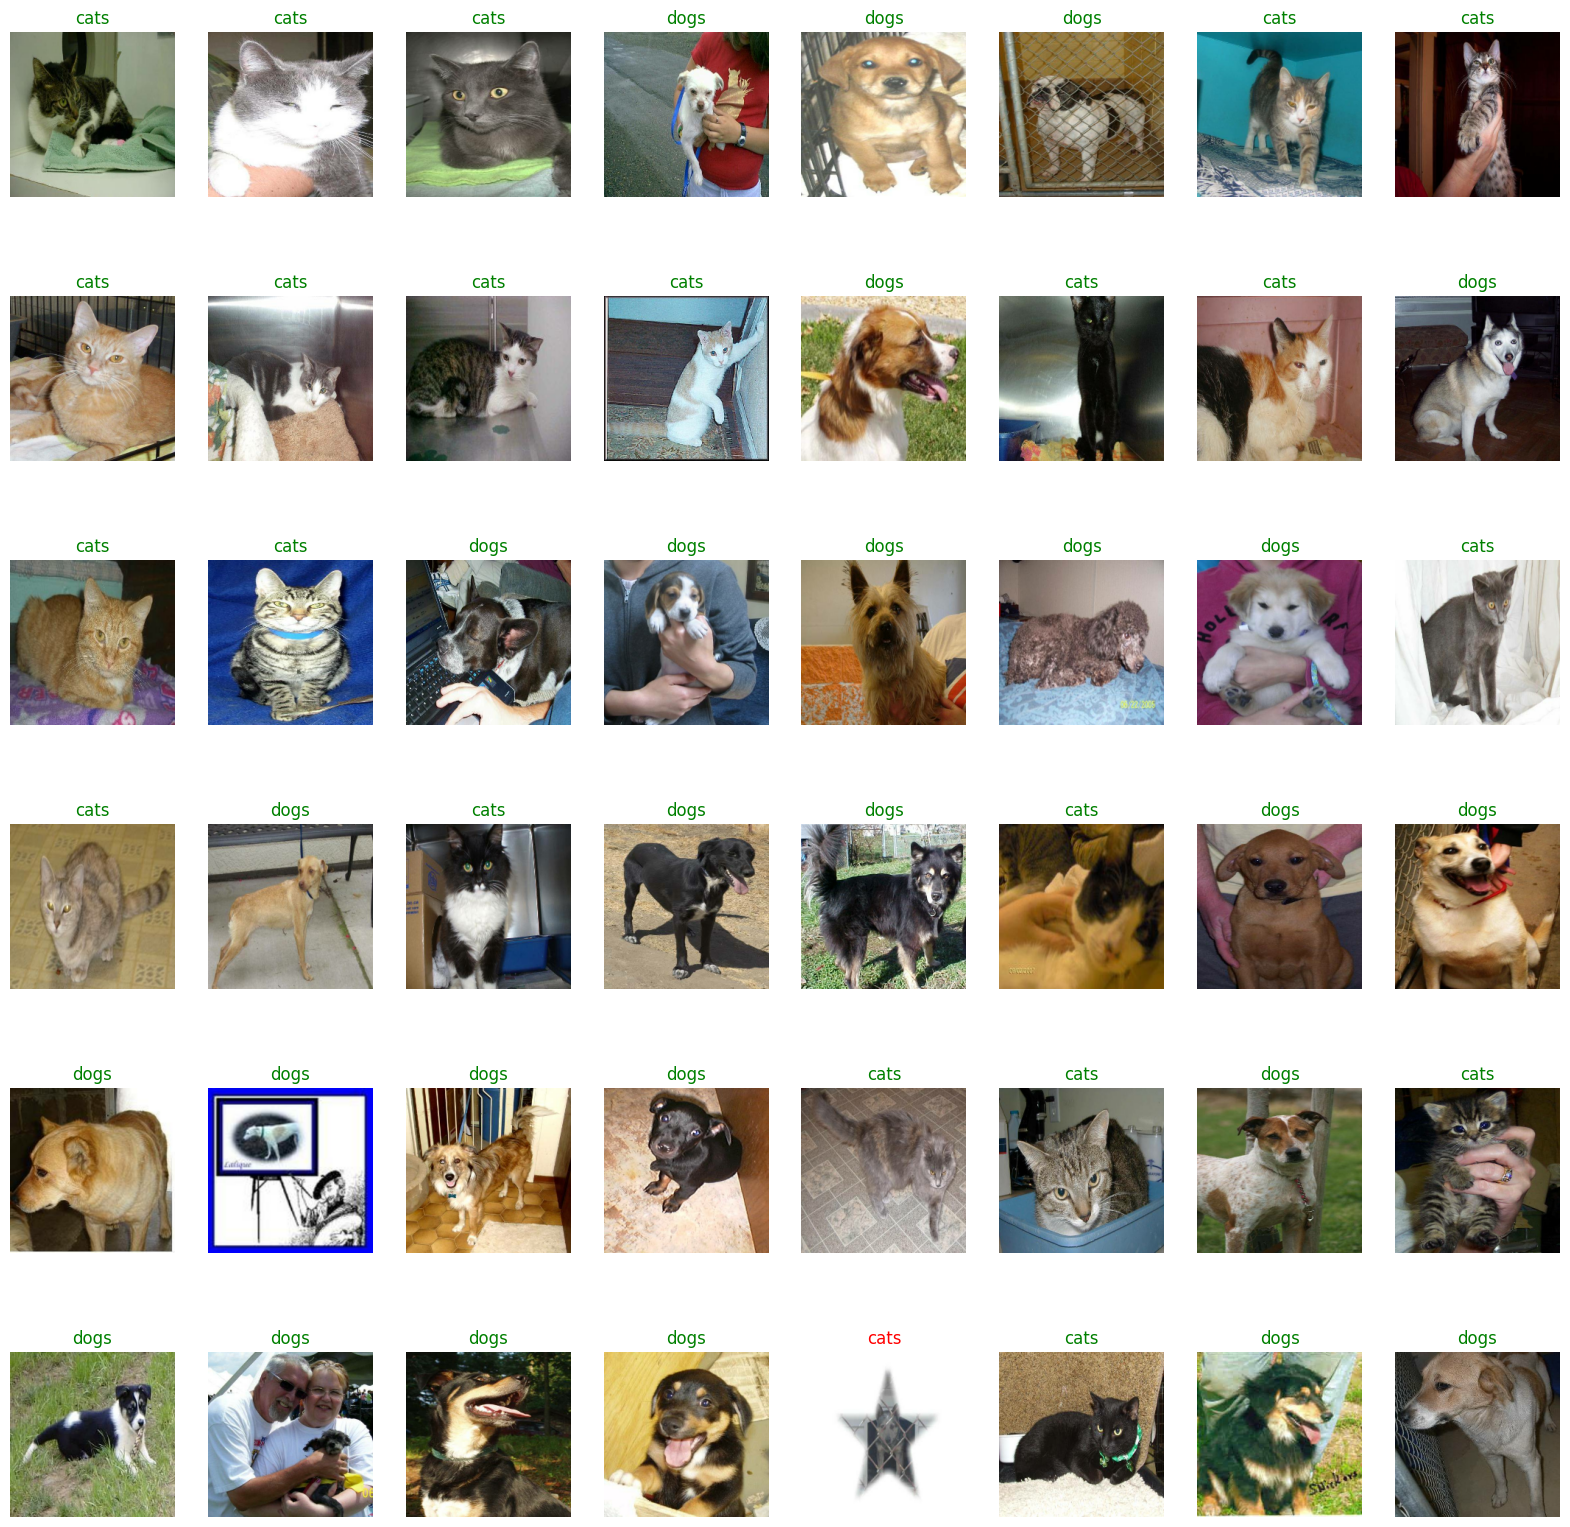

In [22]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    preds_classes = np.argmax(model.predict(images), axis=1)
    
    for i in range(48):
        ax = plt.subplot(6, 8, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        if preds_classes[i] == labels[i]:
            plt.title(class_names[preds_classes[i]], color='g')
        else:
            plt.title(class_names[preds_classes[i]], color='r')
        plt.axis('off')